# Simple MP2RAGE T1-weighted Image Reconstruction

Based on Marques et al. (2010) - Original MP2RAGE method

$$\text{MP2RAGE} = \frac{\text{Re}(\text{SI1}^* \cdot \text{SI2})}{|\text{SI1}|^2 + |\text{SI2}|^2}$$

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

## 1. Load Data

In [2]:
# Input files
ti1_mag = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_t787.nii.gz"
ti2_mag = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_t2387.nii.gz"
ti1_phase = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_ph_t787.nii.gz"
ti2_phase = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_ph_t2387.nii.gz"

output_dir = os.path.dirname(ti1_mag)

print("Loading magnitude images...")
ti1_mag_img = nib.load(ti1_mag)
ti2_mag_img = nib.load(ti2_mag)
SI1 = ti1_mag_img.get_fdata()
SI2 = ti2_mag_img.get_fdata()

print("Loading phase images...")
ti1_phase_img = nib.load(ti1_phase)
ti2_phase_img = nib.load(ti2_phase)
phase1 = ti1_phase_img.get_fdata()
phase2 = ti2_phase_img.get_fdata()

print(f"Data shape: {SI1.shape}")
print(f"TI1 magnitude range: [{SI1.min():.0f}, {SI1.max():.0f}]")
print(f"TI2 magnitude range: [{SI2.min():.0f}, {SI2.max():.0f}]")
print(f"Phase range: [{phase1.min():.3f}, {phase1.max():.3f}] rad")

Loading magnitude images...
Loading phase images...
Data shape: (224, 224, 120)
TI1 magnitude range: [0, 2469299]
TI2 magnitude range: [0, 2487738]
Phase range: [-3.142, 3.140] rad


## 2. Visualize Input Data

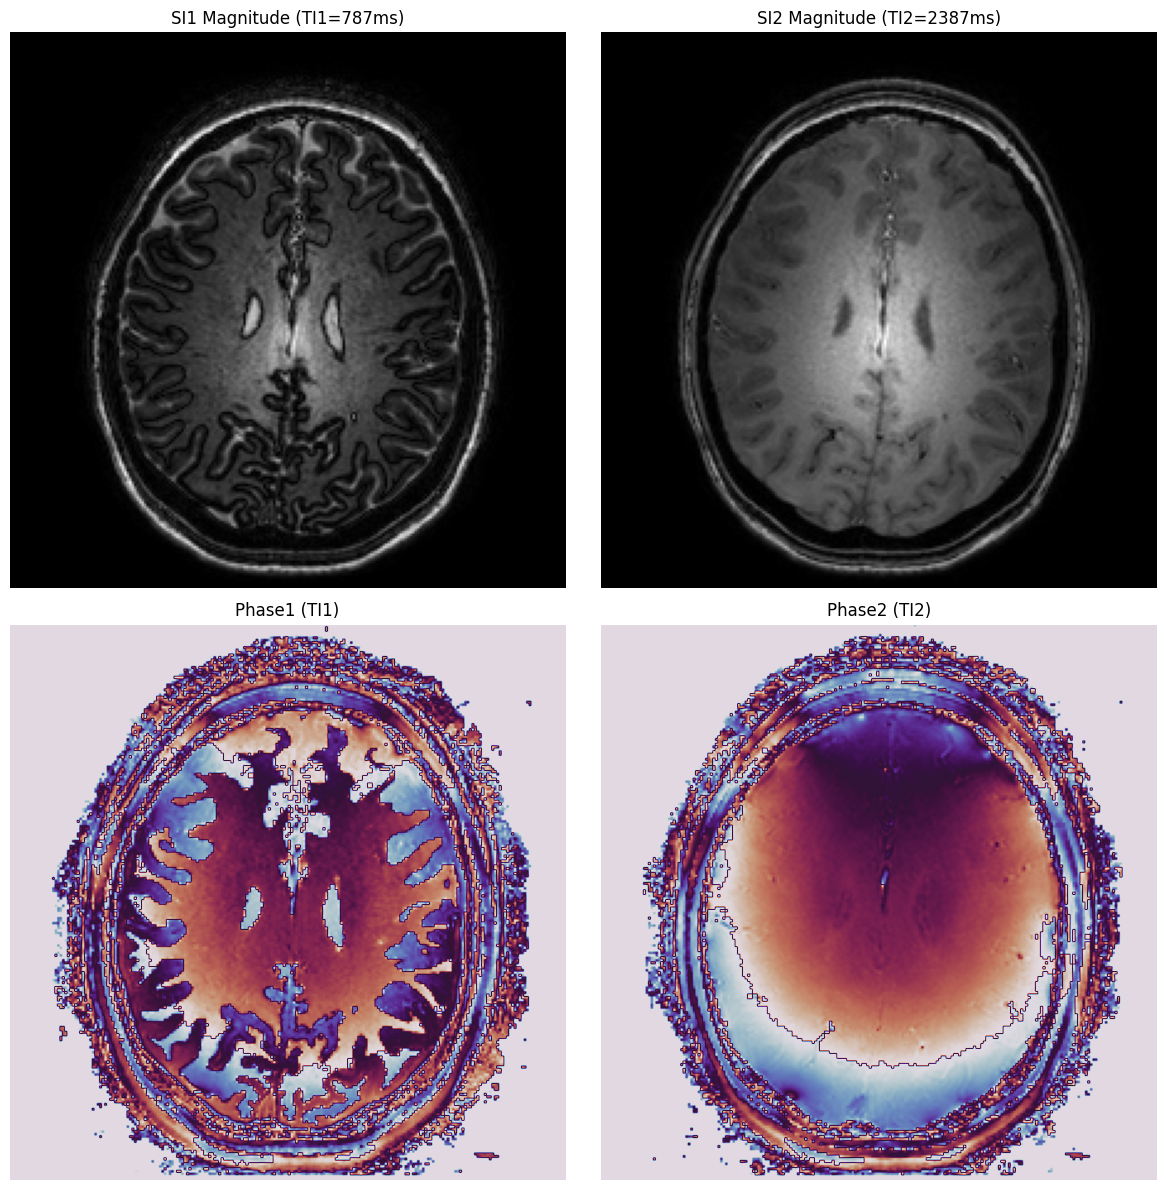

In [4]:
slice_idx = SI1.shape[2] // 2

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(SI1[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0, 0].set_title('SI1 Magnitude (TI1=787ms)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(SI2[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0, 1].set_title('SI2 Magnitude (TI2=2387ms)', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(phase1[:, :, slice_idx].T, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title('Phase1 (TI1)', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(phase2[:, :, slice_idx].T, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title('Phase2 (TI2)', fontsize=12)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 3. Compute MP2RAGE

Original MP2RAGE formula:

$$\text{MP2RAGE} = \frac{\text{Re}(\text{SI1}^* \cdot \text{SI2})}{|\text{SI1}|^2 + |\text{SI2}|^2}$$

where SI1* is the complex conjugate of SI1.

In [5]:
print("Computing MP2RAGE...")

# Create complex images from magnitude and phase
SI1_complex = SI1 * np.exp(1j * phase1)
SI2_complex = SI2 * np.exp(1j * phase2)

# Complex conjugate of SI1
SI1_conj = np.conj(SI1_complex)

# MP2RAGE formula
numerator = np.real(SI1_conj * SI2_complex)
denominator = np.abs(SI1_complex)**2 + np.abs(SI2_complex)**2

# Avoid division by zero
epsilon = 1e-10
MP2RAGE = numerator / (denominator + epsilon)

print(f"MP2RAGE range: [{MP2RAGE.min():.4f}, {MP2RAGE.max():.4f}]")
print(f"MP2RAGE mean: {MP2RAGE.mean():.4f}")
print(f"MP2RAGE std: {MP2RAGE.std():.4f}")

Computing MP2RAGE...
MP2RAGE range: [-0.5000, 0.5000]
MP2RAGE mean: 0.0307
MP2RAGE std: 0.2495


## 4. Visualize MP2RAGE Result

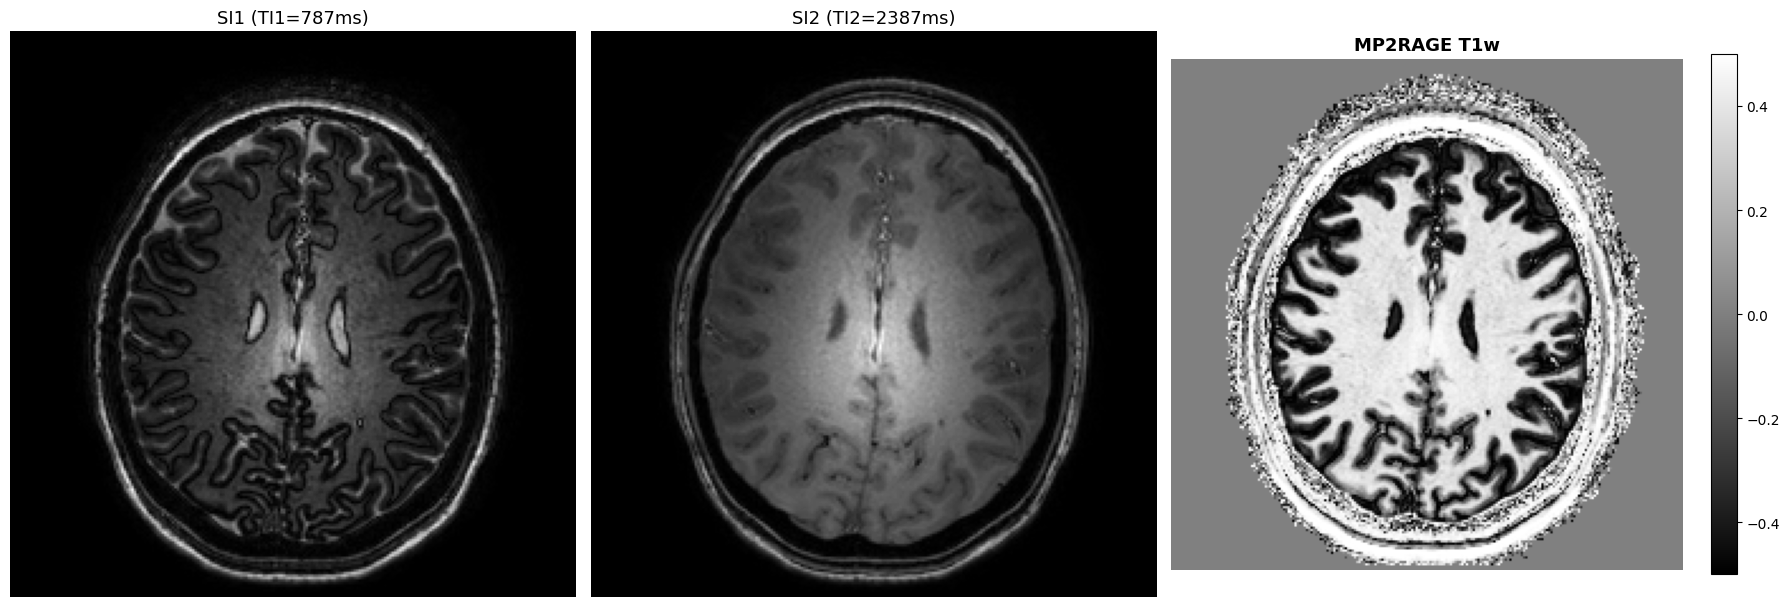

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(SI1[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0].set_title('SI1 (TI1=787ms)', fontsize=13)
axes[0].axis('off')

axes[1].imshow(SI2[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[1].set_title('SI2 (TI2=2387ms)', fontsize=13)
axes[1].axis('off')

im = axes[2].imshow(MP2RAGE[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[2].set_title('MP2RAGE T1w', fontsize=13, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

## 5. Multi-slice Visualization

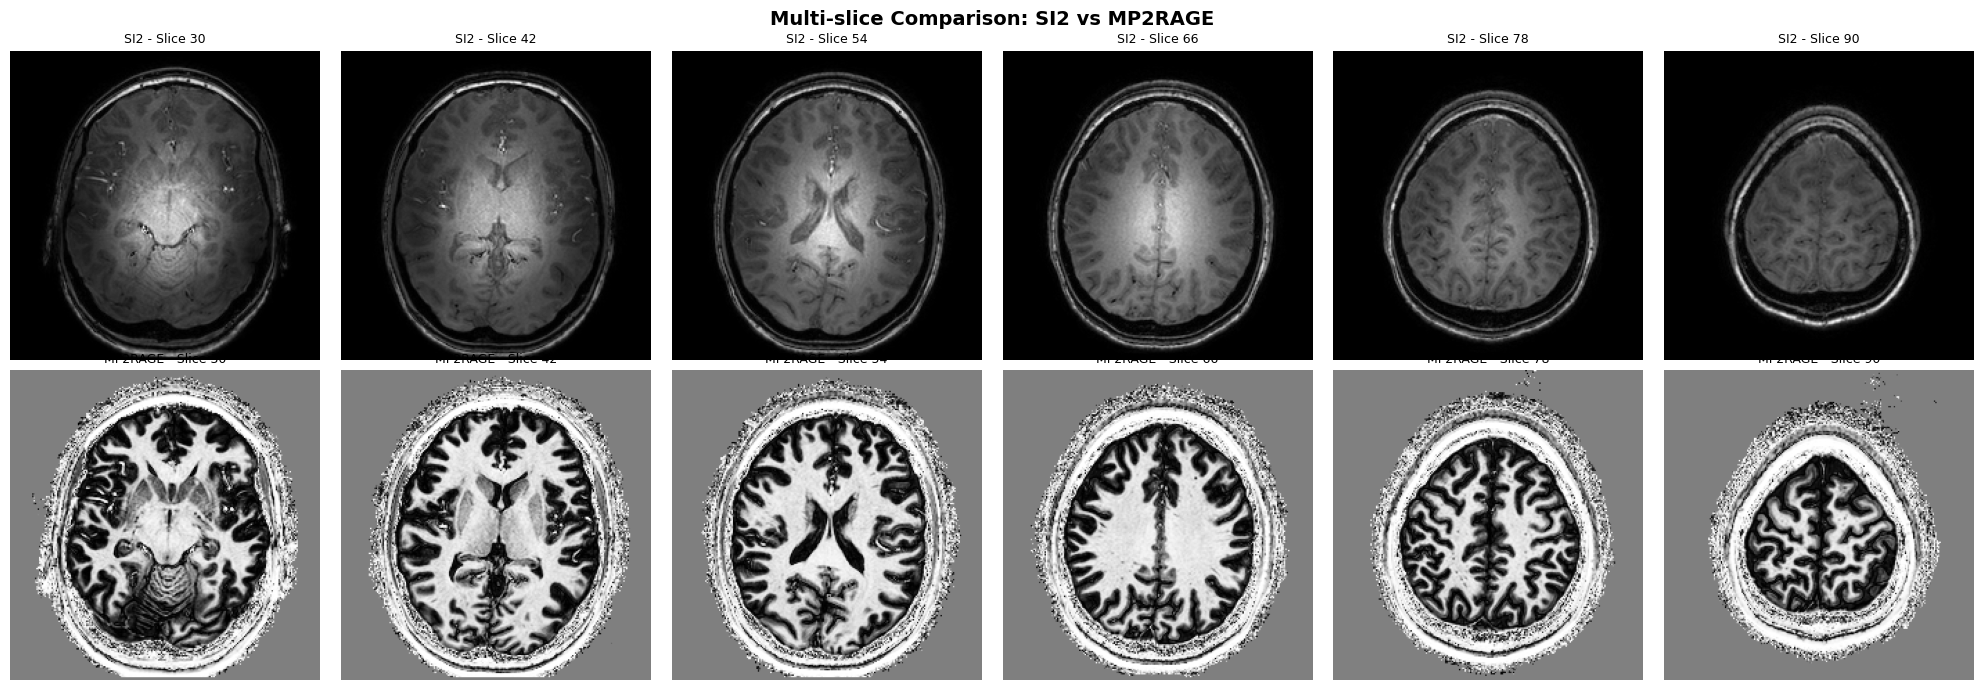

In [7]:
# Show multiple slices
n_slices = 6
slice_indices = np.linspace(SI1.shape[2]//4, 3*SI1.shape[2]//4, n_slices, dtype=int)

fig, axes = plt.subplots(2, n_slices, figsize=(20, 7))

for i, slice_idx in enumerate(slice_indices):
    # Top row: SI2 for reference
    axes[0, i].imshow(SI2[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0, i].set_title(f'SI2 - Slice {slice_idx}', fontsize=9)
    axes[0, i].axis('off')
    
    # Bottom row: MP2RAGE
    axes[1, i].imshow(MP2RAGE[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[1, i].set_title(f'MP2RAGE - Slice {slice_idx}', fontsize=9)
    axes[1, i].axis('off')

plt.suptitle('Multi-slice Comparison: SI2 vs MP2RAGE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Save MP2RAGE Output

In [ ]:
print("Saving MP2RAGE image...")

mp2rage_img = nib.Nifti1Image(MP2RAGE, ti1_mag_img.affine, ti1_mag_img.header)
mp2rage_output = os.path.join(output_dir, "PARREC_WIPPSIR1mm3SENSE_20141016132749_15_MP2RAGE.nii.gz")
nib.save(mp2rage_img, mp2rage_output)

print(f"✓ Saved: {mp2rage_output}")
print("\nDone!")

## Summary

This notebook computes the standard MP2RAGE T1-weighted image from dual inversion time data.

**MP2RAGE Formula:**
- Combines complex signals from two inversion times
- Uses complex conjugate multiplication to handle phase
- Normalizes by sum of squared magnitudes to remove B1 bias

**Expected result:**
- White matter should appear bright
- Gray matter should appear darker
- CSF should be dark
- Good GM/WM contrast throughout the brain